# Collaborative Filtering dan Tren Analisis Penjualan (Prediksi dan Rekomendasi)

In [1]:
pip install pandas scikit-learn matplotlib seaborn openpyxl lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\user1\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


✅ Data berhasil dimuat.
🚀 Memulai Feature Engineering & Preprocessing...
✅ Preprocessing Selesai.


🚀 Memulai Pelatihan Model dengan GridSearchCV...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 17
[LightGBM] [Info] Start training from score 1.028309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

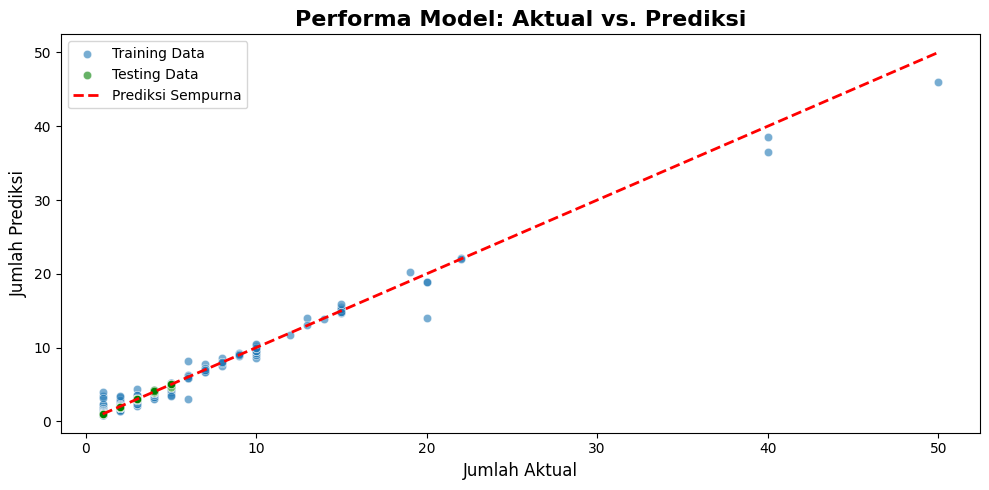

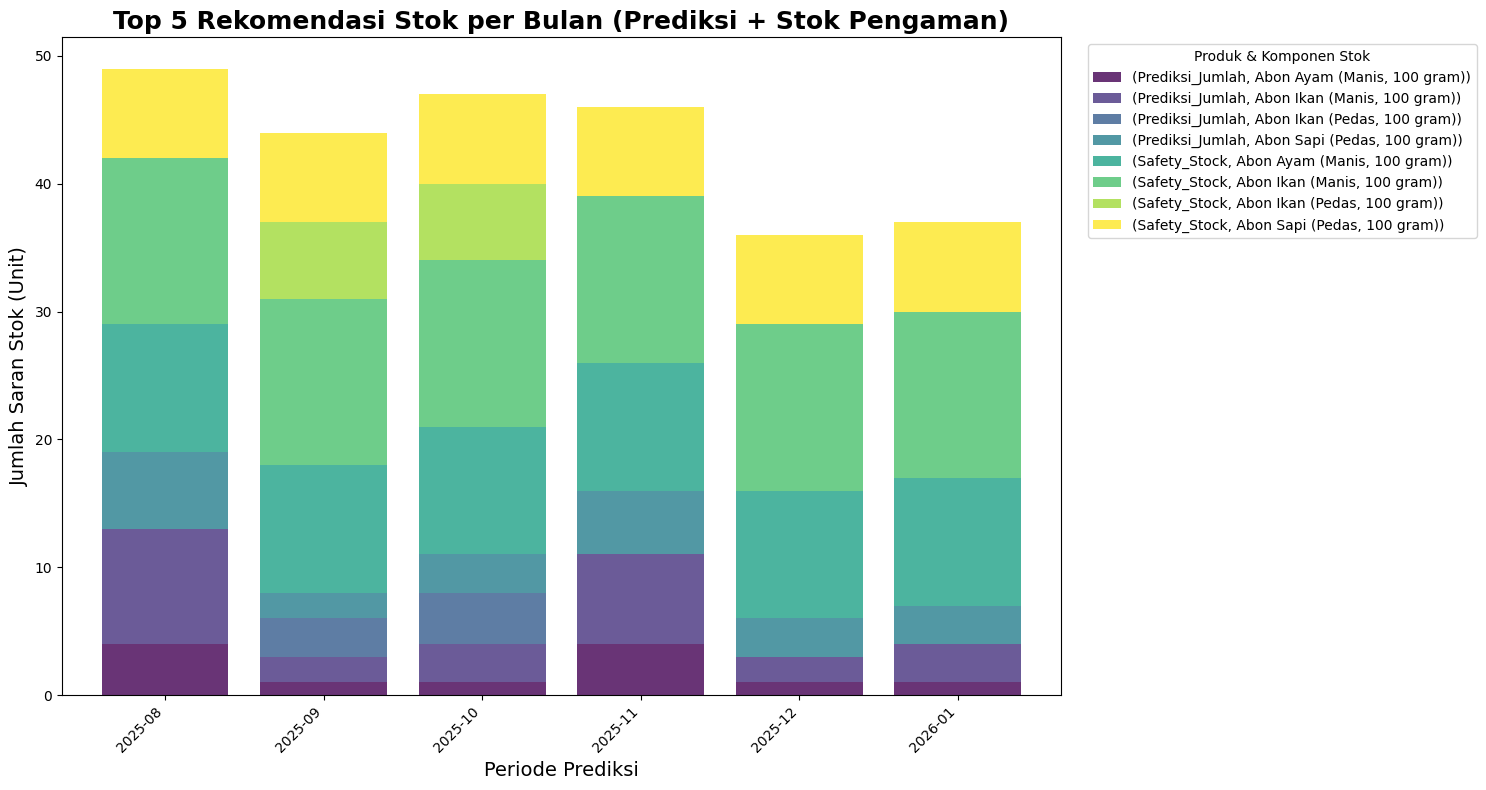

In [ ]:
# --- 0. Instalasi & Import Library ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

warnings.filterwarnings('ignore')

# --- 1. Memuat & Membersihkan Data ---
try:
    file_path = 'Sistem Rekomendasi Abon - Dataset Abon Ummi.csv'
    df = pd.read_csv(file_path, on_bad_lines='skip')
    print("Data berhasil dimuat.")
except FileNotFoundError:
    print("Error: File tidak ditemukan.")
    # Data dummy
    data = {'Tanggal': ['01/01/2025'], 'Nama Abon': ['Abon Sapi'], 'Jenis Abon': ['Original'], 'Berat Kemasan': ['100 gram'], 'Jumlah': [10], 'Harga Satuan': ['Rp50.000,00'], 'Total': ['Rp500.000,00']}
    df = pd.DataFrame(data)

# --- 2. Feature Engineering & Preprocessing (MAKSIMAL) ---
print("Memulai Feature Engineering & Preprocessing...")
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
df['Harga Satuan'] = df['Harga Satuan'].astype(str).str.replace(r'[Rp.,]', '', regex=True).astype(float)
if 'Total' in df.columns:
    df = df.drop(columns=['Total'])
df = df.sort_values(by=['Tanggal', 'Nama Abon']).reset_index(drop=True)

df['Bulan'] = df['Tanggal'].dt.month
df['Tahun'] = df['Tanggal'].dt.year
df['Minggu_dalam_Tahun'] = df['Tanggal'].dt.isocalendar().week.astype(int)
df['Hari_dalam_Minggu'] = df['Tanggal'].dt.dayofweek
df['Pekan_dalam_Bulan'] = (df['Tanggal'].dt.day - 1) // 7 + 1
df['Musim_Lebaran'] = df['Bulan'].isin([3, 4]).astype(int)
df['Penjualan_Bulan_Lalu'] = df.groupby(['Nama Abon', 'Jenis Abon', 'Berat Kemasan'])['Jumlah'].shift(1).fillna(0)
df['Penjualan_2Bulan_Lalu'] = df.groupby(['Nama Abon', 'Jenis Abon', 'Berat Kemasan'])['Jumlah'].shift(2).fillna(0)
df['Penjualan_3Bulan_Lalu'] = df.groupby(['Nama Abon', 'Jenis Abon', 'Berat Kemasan'])['Jumlah'].shift(3).fillna(0)
g = df.groupby(['Nama Abon', 'Jenis Abon', 'Berat Kemasan'])['Jumlah']
df['Rata2_Penjualan_3Bulan'] = g.transform(lambda x: x.rolling(window=3, min_periods=1).mean()).fillna(0)
df['Rata2_Penjualan_6Bulan'] = g.transform(lambda x: x.rolling(window=6, min_periods=1).mean()).fillna(0)
df['Std_Penjualan_3Bulan'] = g.transform(lambda x: x.rolling(window=3, min_periods=1).std()).fillna(0)
df['Bulan_Sin'] = np.sin(2 * np.pi * df['Bulan'] / 12)
df['Bulan_Cos'] = np.cos(2 * np.pi * df['Bulan'] / 12)

encoders = {}
for col in ['Nama Abon', 'Jenis Abon', 'Berat Kemasan']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
print("Preprocessing Selesai.")
print("\n" + "="*60 + "\n")

# --- 3. Pelatihan Model (Dengan Objective 'poisson') ---
print("Memulai Pelatihan Model dengan GridSearchCV...")
features = [
    'Nama Abon', 'Jenis Abon', 'Berat Kemasan', 'Harga Satuan', 'Bulan', 'Tahun', 
    'Minggu_dalam_Tahun', 'Hari_dalam_Minggu', 'Pekan_dalam_Bulan', 'Musim_Lebaran',
    'Penjualan_Bulan_Lalu', 'Penjualan_2Bulan_Lalu', 'Penjualan_3Bulan_Lalu',
    'Rata2_Penjualan_3Bulan', 'Rata2_Penjualan_6Bulan', 'Std_Penjualan_3Bulan',
    'Bulan_Sin', 'Bulan_Cos'
]
X = df[features]
y = df['Jumlah']

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

param_grid = {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31], 'max_depth': [7, 10],
    'reg_alpha': [0.1, 0.5], 'reg_lambda': [0.1, 0.5]
}
tscv = TimeSeriesSplit(n_splits=5)

model_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(objective='poisson', random_state=42), 
    param_grid=param_grid, 
    cv=tscv, n_jobs=-1, verbose=0, 
    scoring='neg_mean_squared_error'
)
model_search.fit(X_train, y_train)
best_model = model_search.best_estimator_

# --- 3.5. Evaluasi Model dengan Metrik Lengkap dan Visualisasi ---
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
mae_test = mean_absolute_error(y_test, test_preds)
mape_test = mean_absolute_percentage_error(y_test, test_preds)

print("\n" + "="*60)
print("--- Final Model Evaluation Report ---")
print(f"Best Parameters Found: {model_search.best_params_}")
print("-" * 30)
print(f"Root Mean Squared Error (RMSE) : {rmse_test:.4f}")
print(f"Mean Absolute Error (MAE)    : {mae_test:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test:.2f}%")
print("="*60 + "\n")

# Training Data dan Convert Diagram Scatterplot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_train, y=train_preds, alpha=0.6, label='Training Data')
sns.scatterplot(x=y_test, y=test_preds, alpha=0.6, color='green', label='Testing Data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', lw=2, label='Perfect Prediction')
plt.title('Model Performance: Actual vs. Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Actual Quantity', fontsize=12)
plt.ylabel('Predicted Quantity', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('combined_performance.png')
print("Combined performance chart saved as 'combined_performance.png'")
print("\n" + "="*60 + "\n")

# Latih ulang model terbaik pada SEMUA data historis
print("Retraining the best model on ALL historical data...")
best_model.fit(X, y)
print("Retraining complete.")
print("\n" + "="*60 + "\n")

# --- 4. Prediksi Masa Depan ---
def predict_future_recursive_optimized(model, encoders, df_history, start_date_str, num_months):
    all_predictions = []
    dynamic_history = df_history.copy() 
    produk_unik = dynamic_history[['Nama Abon', 'Jenis Abon', 'Berat Kemasan', 'Harga Satuan']].drop_duplicates().reset_index(drop=True)
    current_date = pd.to_datetime(start_date_str)
    group_keys = ['Nama Abon', 'Jenis Abon', 'Berat Kemasan']
    
    for i in range(num_months):
        future_df = produk_unik.copy()
        future_df['Tanggal'] = current_date
        
        future_df['Bulan'] = future_df['Tanggal'].dt.month
        future_df['Tahun'] = future_df['Tanggal'].dt.year
        future_df['Minggu_dalam_Tahun'] = future_df['Tanggal'].dt.isocalendar().week.astype(int)
        future_df['Hari_dalam_Minggu'] = future_df['Tanggal'].dt.dayofweek
        future_df['Pekan_dalam_Bulan'] = (df['Tanggal'].dt.day - 1) // 7 + 1
        future_df['Musim_Lebaran'] = future_df['Bulan'].isin([3, 4]).astype(int)
        future_df['Bulan_Sin'] = np.sin(2 * np.pi * future_df['Bulan'] / 12)
        future_df['Bulan_Cos'] = np.cos(2 * np.pi * future_df['Bulan'] / 12)
        
        for lag in [1, 2, 3]:
            lag_date = current_date - pd.DateOffset(months=lag)
            lag_hist = dynamic_history[(dynamic_history['Tahun'] == lag_date.year) & (dynamic_history['Bulan'] == lag_date.month)]
            lag_sales = lag_hist[group_keys + ['Jumlah']].drop_duplicates(subset=group_keys, keep='last')
            feature_name = f'Penjualan_{lag}Bulan_Lalu' if lag > 1 else 'Penjualan_Bulan_Lalu'
            lag_sales = lag_sales.rename(columns={'Jumlah': feature_name})
            future_df = pd.merge(future_df, lag_sales, on=group_keys, how='left')
        
        hist_3m = dynamic_history[dynamic_history['Tanggal'] >= current_date - pd.DateOffset(months=3)]
        stats_3m = hist_3m.groupby(group_keys)['Jumlah'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'Rata2_Penjualan_3Bulan', 'std': 'Std_Penjualan_3Bulan'})
        future_df = pd.merge(future_df, stats_3m, on=group_keys, how='left')
        
        hist_6m = dynamic_history[dynamic_history['Tanggal'] >= current_date - pd.DateOffset(months=6)]
        stats_6m = hist_6m.groupby(group_keys)['Jumlah'].agg(['mean']).reset_index().rename(columns={'mean': 'Rata2_Penjualan_6Bulan'})
        future_df = pd.merge(future_df, stats_6m, on=group_keys, how='left')
        
        future_df.fillna(0, inplace=True)
        
        X_future = future_df[features]
        future_df['Prediksi_Jumlah'] = np.round(np.maximum(0, model.predict(X_future))).astype(int)
        all_predictions.append(future_df)
        
        update_history_df = future_df.copy()
        update_history_df.rename(columns={'Prediksi_Jumlah': 'Jumlah'}, inplace=True)
        
        dynamic_history = pd.concat([dynamic_history, update_history_df[df.columns]], ignore_index=True)
        current_date += pd.DateOffset(months=1)
        
    return pd.concat(all_predictions, ignore_index=True)

print("Starting Prediction with Optimized Function...")
start_date = '2025-08-01'
months_to_predict = 6
predictions_df = predict_future_recursive_optimized(best_model, encoders, df, start_date, months_to_predict)
print(f"Prediction Complete.")
print("\n" + "="*60 + "\n")

# --- 5. Membuat Rekomendasi Aplikatif & Output ---
print("Creating Stock Recommendations with Safety Stock...")
group_keys = ['Nama Abon', 'Jenis Abon', 'Berat Kemasan']
historical_std = df.groupby(group_keys)['Jumlah'].std().fillna(0).reset_index()
historical_std.rename(columns={'Jumlah': 'Std_Histori'}, inplace=True)

predictions_df = pd.merge(predictions_df, historical_std, on=group_keys, how='left').fillna(0)

SERVICE_LEVEL_Z = 1.64
LEAD_TIME_BULAN = 1
predictions_df['Safety_Stock'] = (SERVICE_LEVEL_Z * predictions_df['Std_Histori'] * np.sqrt(LEAD_TIME_BULAN)).round()
predictions_df['Saran_Stok'] = (predictions_df['Prediksi_Jumlah'] + predictions_df['Safety_Stock']).astype(int)

def generate_recommendations(df_pred):
    df_pred['Peringkat'] = df_pred.groupby('Periode')['Saran_Stok'].rank(method='dense', ascending=False)
    quantiles_df = df_pred.groupby('Periode')['Saran_Stok'].quantile([0.25, 0.75]).unstack()
    quantiles_df.rename(columns={0.25: 'q25', 0.75: 'q75'}, inplace=True)
    df_pred_with_quantiles = pd.merge(df_pred, quantiles_df, on='Periode', how='left').fillna(0)
    conditions = [
        df_pred_with_quantiles['Saran_Stok'] >= df_pred_with_quantiles['q75'],
        (df_pred_with_quantiles['Saran_Stok'] < df_pred_with_quantiles['q75']) & (df_pred_with_quantiles['Saran_Stok'] >= df_pred_with_quantiles['q25']),
        df_pred_with_quantiles['Saran_Stok'] < df_pred_with_quantiles['q25']
    ]
    choices = ['🥇 High Priority', '🥈 Medium Priority', '🥉 Low Priority']
    df_pred['Rekomendasi_Stok'] = np.select(conditions, choices, default='Standard Stock')
    
    kolom_output = [
        'Periode', 'Produk', 'Prediksi_Jumlah', 
        'Safety_Stock', 'Saran_Stok', 'Peringkat', 'Rekomendasi_Stok'
    ]
    return df_pred[kolom_output]

for col, le in encoders.items():
    predictions_df[col] = le.inverse_transform(predictions_df[col])
predictions_df['Produk'] = predictions_df['Nama Abon'] + ' (' + predictions_df['Jenis Abon'] + ', ' + predictions_df['Berat Kemasan'] + ')'
predictions_df['Periode'] = predictions_df['Tanggal'].dt.strftime('%Y-%m')

recommendations = generate_recommendations(predictions_df)
output_file = 'Rekomendasi_Stok_Abon_Ummi_HYBRID.xlsx'
with pd.ExcelWriter(output_file) as writer:
    recommendations.to_excel(writer, sheet_name='All Recommendations', index=False)
    for periode, data in recommendations.groupby('Periode'):
        data.sort_values(by='Peringkat').to_excel(writer, sheet_name=f'Recommendation_{periode}', index=False)
print(f"Complete recommendations saved to file: '{output_file}'")

# --- 6. Menampilkan Narasi Rekomendasi Prioritas di Terminal ---
def tampilkan_narasi_prioritas(rekomendasi_df, top_n=3):
    print("\n" + "="*60)
    print("MONTHLY STOCK RECOMMENDATION SUMMARY".center(60))
    print("="*60)
    semua_periode = sorted(rekomendasi_df['Periode'].unique())
    for periode in semua_periode:
        df_periode = rekomendasi_df[rekomendasi_df['Periode'] == periode].copy()
        nama_bulan = pd.to_datetime(periode).strftime('%B %Y')
        top_produk = df_periode.sort_values(by='Peringkat').head(top_n)
        print(f"\n--- Priority Stock for {nama_bulan} ---")
        for i, row in top_produk.iterrows():
            try:
                nama, detail = row['Produk'].split(' (')
                rasa, berat = detail.replace(')', '').split(', ')
                print(f"{int(row['Peringkat'])}) {nama}, Flavor: {rasa}, Variant: {berat.capitalize()}: {row['Saran_Stok']} units (Forecast: {row['Prediksi_Jumlah']}, Safety Stock: {int(row['Safety_Stock'])})")
            except ValueError:
                print(f"{int(row['Peringkat'])}) {row['Produk']}: {row['Saran_Stok']} units")

tampilkan_narasi_prioritas(recommendations, top_n=3)

# --- 7. Visualisasi Tambahan ---
print("\n" + "="*60)
print("Creating Additional Diagrams...")

# Diagram Rekomendasi Stok Bulanan
top5_per_periode = recommendations.groupby('Periode').apply(
    lambda x: x.sort_values('Peringkat').head(5)
).reset_index(drop=True).drop_duplicates(subset=['Periode', 'Produk'])

plot_data = top5_per_periode.pivot_table(
    index='Periode', 
    columns='Produk', 
    values=['Prediksi_Jumlah', 'Safety_Stock'],
    fill_value=0
)

if not plot_data.empty:
    plot_data.plot(
        kind='bar', 
        stacked=True, 
        figsize=(15, 8), 
        width=0.8, 
        colormap='viridis',
        alpha=0.8
    )

    plt.title('Top 5 Recommended Stock per Month (Forecast + Safety Stock)', fontsize=18, fontweight='bold')
    plt.xlabel('Prediction Period', fontsize=14)
    plt.ylabel('Total Recommended Stock (Units)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Product & Stock Component', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('rekomendasi_stok_bulanan.png')
    print("Monthly stock recommendation chart saved as 'rekomendasi_stok_bulanan.png'")
